In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random as rd
import tensorflow_hub as hub
from tensorflow.keras.applications import VGG16

#4. Modelo AlexNet desde cerp en TensorFlow

#4.1 Carga de los datos
Cargamos los datos de la base CIFAR-10, que contiene imágenes clasificadas en 10 categorías. Importamos los conjuntos de entrenamiento para la red y el conjunto de prueba para ver como de desempeña el modelo ante datos nuevos. Debemos de ajustar los valores de los píxeles para normalizarlos ya que originalmente los píxeles van de 0 a 255, pero al dividirlos entre 2 resulta 127.5 y al restar 1 quedan dentro del rango -1 a 1.

Después, partimos los datos en lotes para el entrenamiento. Al agrupar las imágenes en conjuntos de 30 y mezclarlas aleatoriamente (con shuffle), se optimiza el proceso de aprendizaje, esto permite que el modelo generalice mejor y no dependa del orden de las muestras. En el conjunto de prueba, solo se divide en lotes sin mezclar, ya que estos datos no los ve el modelo cuando se esta entrenado y no tiene caso cambiar el orden de las imagenes.

In [2]:
#Cargar y preparar los datos de la base de CIFAR 10
(x_entren, y_entren), (x_prueba, y_prueba) = tf.keras.datasets.cifar10.load_data()

# Normalizar imagenes entre -1 y 1, donde l valor maximo de un pixel y al divirlo ente 2 = 127.5 quedando en un rango de 0 a 2 y al restar el -1 queda entre -1 y 1
x_entren = (x_entren.astype('float32') / 127.5) - 1.0
x_prueba = (x_prueba.astype('float32') / 127.5) - 1.0

#Crear datasets
lote = 30
ds_entren = tf.data.Dataset.from_tensor_slices((x_entren, y_entren))
ds_entren = ds_entren.shuffle(1000).batch(lote)

ds_prueba = tf.data.Dataset.from_tensor_slices((x_prueba, y_prueba)).batch(lote)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


##4.2 Creación del modelo AlexNet
De igual manera que en PyTorch, vamos a crear AlexNet usando las 11 capas mencionadas: 5 capas convolucionales, 3 capas Maxpooling y 3 capas densasa. Nuevamente extraemos las caracteristicas con las capas convolucionales y usamos ReLU al final de la capa para despues aplicar maxpooling. Finalmente, aplanamos los tensores producidos en el bloque convolucional y defininimos las capas densas en donde llegaran las caracteristicas extraidas y tendran una salida de 10 neuronas que son las clases a clasificar. Lo que resalta al definir el modelo en TesorFlow, es la facilidad de agregar capas, es más sencillo que PyTorch y la estructura es más entendible a primera vista.

In [3]:
#Definir el modelo AlexNet con TensorFlow
class AlexNet(Model):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        #Capas Convolucionales y Maxpooling
        self.caracteristicas = tf.keras.Sequential([
            layers.Conv2D(96, 3, padding='same', activation='relu', input_shape=(32, 32, 3)), #Conv1: recibe las imagenes
            layers.MaxPooling2D(3, strides=2, padding='valid'), #Maxpool1
            layers.Conv2D(256, 3, padding='same', activation='relu'), #Conv2
            layers.MaxPooling2D(3, strides=2, padding='valid'), #Maxpool2
            layers.Conv2D(384, 3, padding='same', activation='relu'), #Conv3
            layers.Conv2D(384, 3, padding='same', activation='relu'), #Conv4
            layers.Conv2D(256, 3, padding='same', activation='relu'), #Conv5
            layers.MaxPooling2D(3, strides=2, padding='valid') #Maxpool3
        ])

        #Capas Densas
        self.clasificador = tf.keras.Sequential([
            layers.Flatten(), #Aplanar las entradas qu
            layers.Dense(4096, activation='relu'),
            layers.Dense(4096, activation='relu'),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        x = self.caracteristicas(x)
        x = self.clasificador(x)
        return x

#4.3 Entrenamiento del modelo
Para el entrenamiento, es muy sencillo compilar y entrenar el modelo, ya que al compilarlo solo se define el optimizador, que en este caso fue el mismo que en los demás modelo (Descenso del Gradiente Estocástico), y la función de perdida tambien fue la misma (Entropia Cruzada). Con el metodo _fit_ entrenamos el modelo y usamos 20 epocas, esto es bastante sencillo si comporamos la cantidad de codigo empleado en PyTorch.

In [4]:
#Compilar modelo
modelo = AlexNet()
modelo.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#Entrenamiento
historial = modelo.fit(ds_entren, epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.2421 - loss: 2.0359
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.5005 - loss: 1.3786
Epoch 3/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.6012 - loss: 1.1203
Epoch 4/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.6694 - loss: 0.9389
Epoch 5/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.7178 - loss: 0.8055
Epoch 6/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.7592 - loss: 0.6924
Epoch 7/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7887 - loss: 0.6062
Epoch 8/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8114 - loss: 0.5369
Epoch 9/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.8390 - loss: 0.4635
Epoch 10/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.8624 - loss: 0.3972
Epoch 11/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8848 - loss: 0.3293
Epoch 12

Al finalizar el entrenamiento, el acuracy fue del 98% y una perdida de 0.0468 tardando 10 min aproximadamente pero a diferencia de PyTorch, el desempeño fue mejor en el entrenamiento.Sin emnargo, en la precisión del conjunto de prueba fue casi la misma, obteniendo un 80.4%.

In [5]:
#Evaluación del modelo
pérdida_prueba, precisión_prueba = modelo.evaluate(ds_prueba)
print(f'\nPrecisión en conjuto de prueba: {precisión_prueba*100:.2f}%')

334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8126 - loss: 0.9261

Precisión en conjuto de prueba: 80.76%


In [6]:
#Reporte de clasificación
predichos = []
reales = []
for imgs, etiq in ds_prueba:
    logits = modelo.predict(imgs)
    predichos.extend(tf.argmax(logits, axis=1).numpy())
    reales.extend(etiq.numpy().flatten())

clases = ['avión', 'auto', 'pájaro', 'gato', 'ciervo',
          'perro', 'rana', 'caballo', 'barco', 'camión']

print("\nReporte de clasificación:")
print(classification_report(reales, predichos, target_names=clases, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


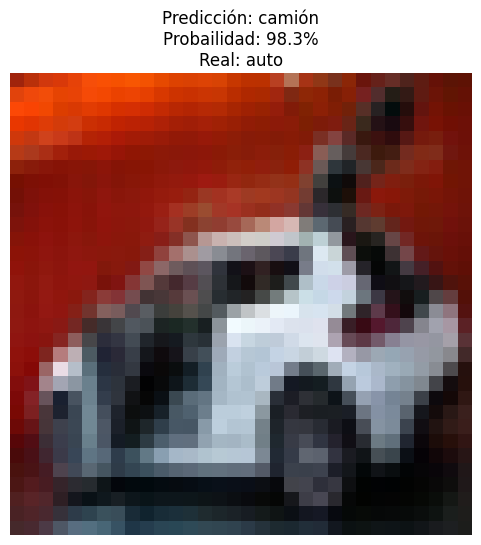

In [7]:
#Visualización de predicciones
lote_prueba = next(iter(ds_prueba))
imagenes, etiquetas = lote_prueba
índice = rd.randint(0, imagenes.shape[0] - 1)

#Obtener predicción
imagen = imagenes[índice]
etiqueta_real = etiquetas[índice].numpy().item()
logits = modelo.predict(tf.expand_dims(imagen, axis=0))
probabilidades = tf.nn.softmax(logits).numpy()
confianza = np.max(probabilidades) * 100
clase_predicha = np.argmax(probabilidades)

#Imagen para visualización
imagen_mostrar = (imagen * 0.5 + 0.5).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(imagen_mostrar)
plt.title(f"Predicción: {clases[clase_predicha]}\n"
          f"Probailidad: {confianza:.1f}%\n"
          f"Real: {clases[etiqueta_real]}")
plt.axis('off')
plt.show()

#4. AlexNet preentrenado
Dado que no se pueden inicalizar los pesos como en AlexNet de Pytorch, se opto po usar VGG16.

#4.1 Cargar el modelo
De nuevo, se cargan los dastos de entrenamiento y prueba pero se carga el modelo VGG16 con sus respectivos pesos y los "congelamos", solo entrenaremos la capa final.

In [10]:
#Cargar datos CIFAR-10
(x_entren, y_entren), (x_prueba, y_prueba) = tf.keras.datasets.cifar10.load_data()

#Preprocesamiento para VGG16
def preprocesar_vgg(imagenes, etiquetas):
    imagenes = tf.image.resize(imagenes, [224, 224]) #VGG16 requiere imagenes de  224x224
    imagenes = tf.keras.applications.vgg16.preprocess_input(imagenes) #Normalización
    return imagenes, etiquetas

# Configurar datasets
lote = 30
ds_entren_vgg = tf.data.Dataset.from_tensor_slices((x_entren, y_entren))
ds_entren_vgg = ds_entren_vgg.map(preprocesar_vgg).shuffle(1000).batch(lote)

ds_prueba_vgg = tf.data.Dataset.from_tensor_slices((x_prueba, y_prueba))
ds_prueba_vgg = ds_prueba_vgg.map(preprocesar_vgg).batch(lote)

#Cargar VGG16 preentrenado
base_vgg = VGG16(
    weights='imagenet',
    include_top=False, #No incluimos las capas densas finales
    input_shape=(224, 224, 3)
)
base_vgg.trainable = False #Congelar pesos preentrenados

#Definir modelo personalizado para CIFAR 10
modelo_vgg = tf.keras.Sequential([
    base_vgg,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [11]:
#Compilar el modelo
modelo_vgg.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

#Entrenar el modelo
historial_vgg = modelo_vgg.fit(
    ds_entren_vgg,
    epochs=10,
    validation_data=ds_prueba_vgg
)

Epoch 1/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 359s 212ms/step - accuracy: 0.7461 - loss: 0.9890 - val_accuracy: 0.8624 - val_loss: 0.4079
Epoch 2/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 354s 211ms/step - accuracy: 0.9272 - loss: 0.2142 - val_accuracy: 0.8721 - val_loss: 0.4259
Epoch 3/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 354s 211ms/step - accuracy: 0.9727 - loss: 0.0803 - val_accuracy: 0.8818 - val_loss: 0.4778
Epoch 4/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 354s 212ms/step - accuracy: 0.9933 - loss: 0.0236 - val_accuracy: 0.8816 - val_loss: 0.5601
Epoch 5/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 382s 211ms/step - accuracy: 0.9987 - loss: 0.0079 - val_accuracy: 0.8837 - val_loss: 0.6117
Epoch 6/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 382s 212ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.8871 - val_loss: 0.6444
Epoch 7/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 353s 211ms/step - accuracy: 1.0000 - loss: 8.5145e-04 - val_accuracy: 0.8886 - val_loss: 0.6721
Epoch 8/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 350s 192ms/step 

##4.2 Analisis del modelo entrenado.

Notemos que es más lento, usando el mismo optimizador.

In [12]:
# Evaluaar el modelo
perdida_vgg, precision_vgg = modelo_vgg.evaluate(ds_prueba_vgg)
print(f'\nPrecisión VGG16: {precision_vgg*100:.2f}%')

334/334 ━━━━━━━━━━━━━━━━━━━━ 54s 160ms/step - accuracy: 0.8866 - loss: 0.7426

Precisión VGG16: 88.93%


In [13]:
# Reporte de clasificación VGG16
predichos_vgg = []
reales_vgg = []
for imgs, etiq in ds_prueba_vgg:
    logits = modelo_vgg.predict(imgs, verbose=0)
    predichos_vgg.extend(tf.argmax(logits, axis=1).numpy())
    reales_vgg.extend(etiq.numpy().flatten())

clases = ['avión', 'auto', 'pájaro', 'gato', 'ciervo',
          'perro', 'rana', 'caballo', 'barco', 'camión']

print("\nReporte de clasificación VGG16:")
print(classification_report(reales_vgg, predichos_vgg, target_names=clases, digits=4))


Reporte de clasificación VGG16:
              precision    recall  f1-score   support

       avión     0.9094    0.9230    0.9161      1000
        auto     0.9529    0.9310    0.9418      1000
      pájaro     0.8647    0.8370    0.8506      1000
        gato     0.7684    0.7930    0.7805      1000
      ciervo     0.8563    0.8700    0.8631      1000
       perro     0.8599    0.8160    0.8374      1000
        rana     0.8943    0.9310    0.9123      1000
     caballo     0.9268    0.9120    0.9194      1000
       barco     0.9240    0.9480    0.9358      1000
      camión     0.9395    0.9320    0.9357      1000

    accuracy                         0.8893     10000
   macro avg     0.8896    0.8893    0.8893     10000
weighted avg     0.8896    0.8893    0.8893     10000



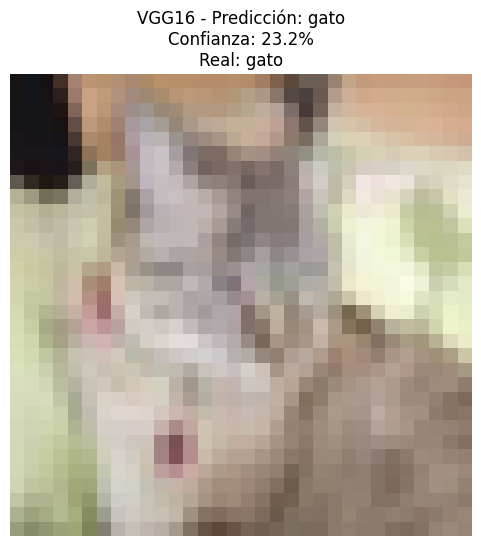

In [14]:
#Visualización de algunas predicciones de VGG16
lote_prueba_vgg = next(iter(ds_prueba_vgg))
imagenes_vgg, etiquetas_vgg = lote_prueba_vgg
índice = rd.randint(0, imagenes_vgg.shape[0] - 1)

#Obtener imagen original sin preprocesar
imagen_original = x_prueba[índice]
imagen_procesada = imagenes_vgg[índice] #Imagen procesada para VGG de 224x224

#Hacer la predicción
logits_vgg = modelo_vgg.predict(tf.expand_dims(imagen_procesada, axis=0), verbose=0)
probabilidades_vgg = tf.nn.softmax(logits_vgg).numpy()
confianza_vgg = np.max(probabilidades_vgg) * 100
clase_predicha_vgg = np.argmax(probabilidades_vgg)
etiqueta_real_vgg = etiquetas_vgg[índice].numpy().item()

#Mostrar imagen original
plt.figure(figsize=(6, 6))
plt.imshow(imagen_original/255.0)
plt.title(f"VGG16 - Predicción: {clases[clase_predicha_vgg]}\n"
         f"Confianza: {confianza_vgg:.1f}%\n"
         f"Real: {clases[etiqueta_real_vgg]}")
plt.axis('off')
plt.show()

#5. Conclusiones Finales

En base a los resultados obtenidos, podemos notar que la implementación en TensorFlow es más sencilla. Sin embargo, la precisión del modelo es casi la misma. Comaparado con los modelos preentreados, el entrenamiento con los datos es más tardado, en particular, VGG16 es más lento. En PyTorch, AlexNet es superior, se arriesga tiempo de entrenamiento pero se gana mucha precisión como se ve en las pruebas realizadas y en las métricas usadas.
Como conclusión. me quedo con la implementación en TensorFlow pero si quisiera hacer algo desde cero para entender la estructura de la red neuronal usaría PyTorch, pues en este ejercicio pude entender el modelo.shas

| Métrica                            | AlexNet creado desde cero (PyTorch) | AlexNet preentrenado (PyTorch) | AlexNet creado desde cero (Keras) | VGG6 preentrenado (Keras)      |
|------------------------------------|-------------------------------------|-------------------------------|----------------------------------|-----------------------------------|
| **Tiempo de entrenamiento**        | 10 min                              | 42 min                        | 10–12 min                        | 1h y 20 min                       |
| **Pérdida (Época 1)**              | 2.30066                             | 0.6339                        | 2.0359                           | 0.9890                            |
| **Pérdida (Época final)**          | 0.31597 (Época 20)                   | 0.0276 (Época 20)             | 0.0473 (Época 20)                | 2.6002e-04 (Época 10)              |
| **Precisión en conjunto de prueba**| **79.22%**                          | **91.16%**                    | **80.76%**                       | **88.93%**                        |


_Resultados usando la GPU de Google Colab._